In [1]:
! pip install -q kaggle
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abhishekrana2511","key":"f8a1d1d85a375f1a9a31a265179ea23c"}'}

In [2]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [3]:
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

100% 1.76G/1.76G [01:02<00:00, 34.8MB/s]
100% 1.76G/1.76G [01:02<00:00, 30.1MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('lung-and-colon-cancer-histopathological-images.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn import metrics
import cv2
import gc
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers


In [6]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Step 2: Data Visualization
path = '/content/lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
classes

['lung_scc', 'lung_n', 'lung_aca']

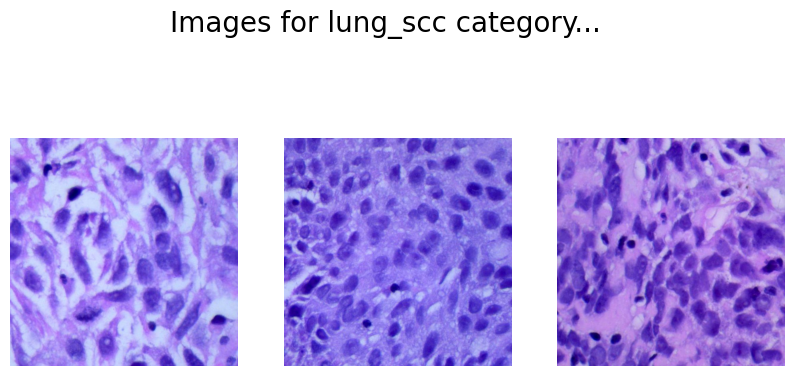

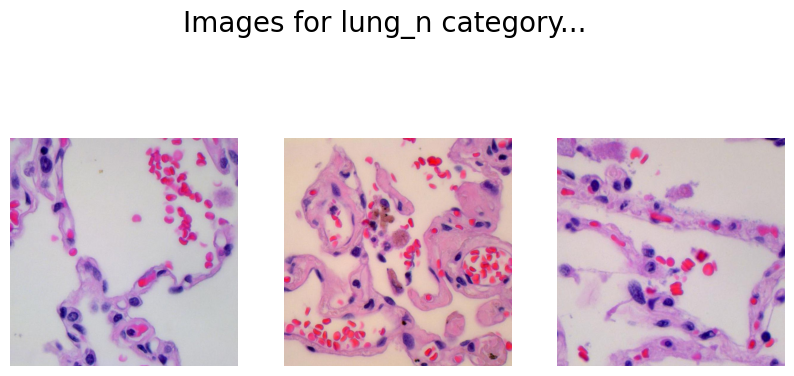

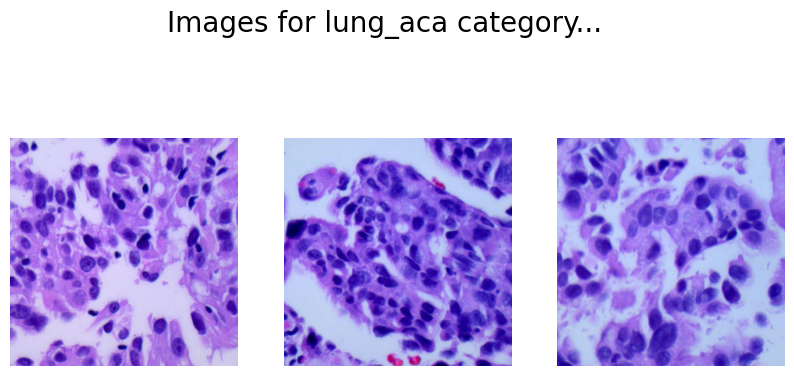

In [8]:
# Display random images from each class
for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)

    # Display 3 random images for each class
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    fig.suptitle(f'Images for {cat} category...', fontsize=20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()


In [9]:
# img = Image.open('/content/drive/MyDrive/New Folder/lung_image_sets/lung_aca/lungaca1.jpeg')
# img = np.array(img)
# # img

In [10]:
# Step 3: Data Preparation for Training
IMG_SIZE = 186
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 8

In [11]:
# Lists to store images and labels
X = []
Y = []

# Loop through each class
for i, cat in enumerate(classes):
    images = glob(f'{path}/{cat}/*.jpeg')
    # print(images)
    # Read and resize each image, append to lists
    for image in images:
        img = cv2.imread(image)
        X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
        Y.append(i)

np.save('X2.npy', X)
np.save('Y2.npy', Y)


# X = np.load('X2.npy')
# Y = np.load('Y2.npy')

In [12]:
# IMG_SIZE = 186
# SPLIT = 0.2
# EPOCHS = 20
# BATCH_SIZE = 16

In [13]:
# Convert lists to NumPy arrays
X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values
one_hot_encoded_Y[300]

array([1, 0, 0], dtype=uint8)

In [14]:
# Split the dataset into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,
                                                  test_size=SPLIT,
                                                  random_state=2022)

In [15]:
# Model Development
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet',
    include_top=False
)

for layer in pre_trained_model.layers:
    layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

87910968/87910968 [==============================] - 3s 0us/step
last layer output shape:  (None, 9, 9, 768)


In [16]:
x = layers.Flatten()(last_output)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
output = layers.Dense(3, activation='softmax')(x)

model = keras.Model(pre_trained_model.input, output)

In [18]:
# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 186, 186, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 92, 92, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 92, 92, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 92, 92, 32)           0         ['batch_normalization[0][0

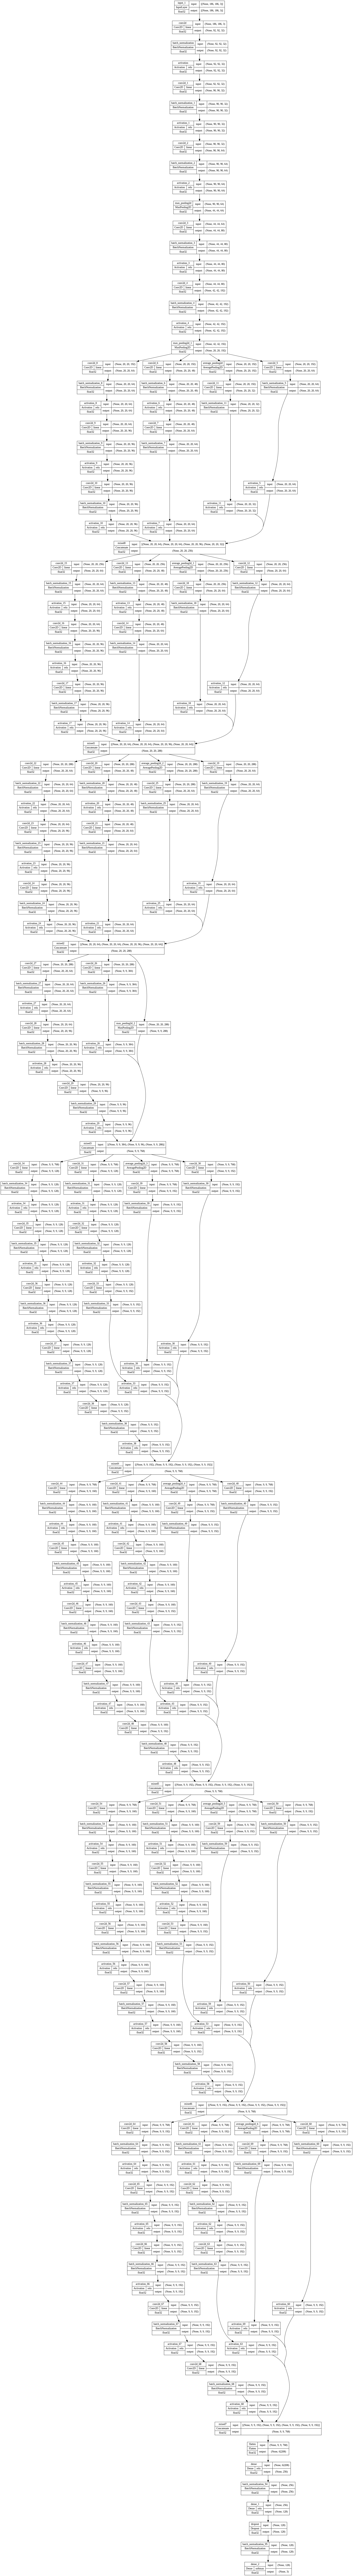

In [20]:
# Visualize the model architecture
keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations=True
)

In [21]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [22]:
# Step 5: Callbacks
# Define custom callback to stop training when validation accuracy reaches 90%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\nValidation accuracy has reached 90%, stopping further training.')
            self.model.stop_training = True

In [23]:
# Define EarlyStopping and ReduceLROnPlateau callbacks
# es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
# lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)

In [24]:
# Step 6: Model Training
# Train the model with the training dataset and validate on the validation dataset
history = model.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1
                    # callbacks=[myCallback()]
                    )

model.save('lung_cancer_detection_model.h5')

Epoch 1/10
1500/1500 [==============================] - 53s 26ms/step - loss: 0.5891 - accuracy: 0.7523 - val_loss: 0.3599 - val_accuracy: 0.8477
Epoch 2/10
1500/1500 [==============================] - 38s 25ms/step - loss: 0.4233 - accuracy: 0.8325 - val_loss: 0.3733 - val_accuracy: 0.8530
Epoch 3/10
1500/1500 [==============================] - 37s 25ms/step - loss: 0.3716 - accuracy: 0.8519 - val_loss: 1.0670 - val_accuracy: 0.9077
Epoch 4/10
1500/1500 [==============================] - 38s 25ms/step - loss: 0.3352 - accuracy: 0.8648 - val_loss: 0.7317 - val_accuracy: 0.7647
Epoch 5/10
1500/1500 [==============================] - 42s 28ms/step - loss: 0.3363 - accuracy: 0.8693 - val_loss: 1.7183 - val_accuracy: 0.9193
Epoch 6/10
1500/1500 [==============================] - 37s 25ms/step - loss: 0.2900 - accuracy: 0.8864 - val_loss: 1.1053 - val_accuracy: 0.8977
Epoch 7/10
1500/1500 [==============================] - 37s 25ms/step - loss: 0.2877 - accuracy: 0.8859 - val_loss: 1.6222 -

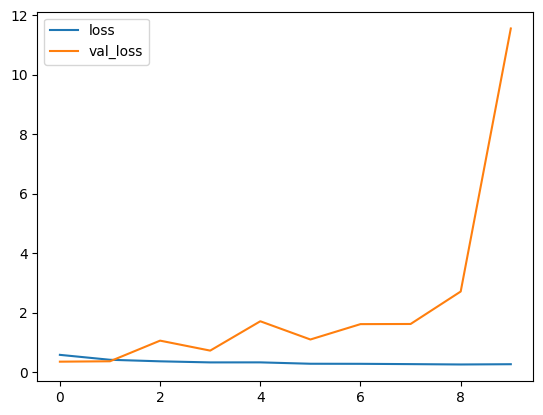

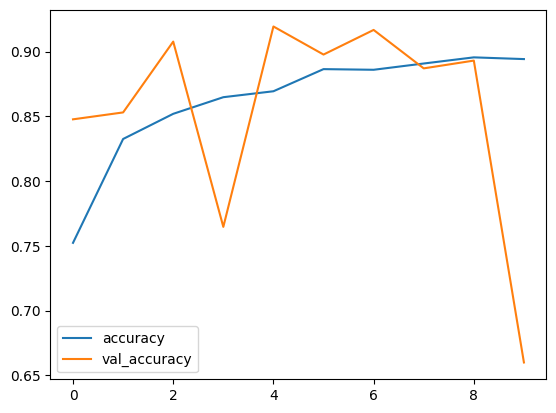

In [25]:
# Step 7: Visualize Training Metrics
# Plot training and validation loss over epochs
# Plot training and validation accuracy over epochs
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()

In [26]:
# Step 8: Model Evaluation
# Predict class labels for the validation dataset
Y_pred = model.predict(X_val)
# print(Y_pred, Y_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)
# print(Y_pred, Y_val)


94/94 [==============================] - 7s 45ms/step


In [27]:
# Confusion matrix and classification report for model evaluation
print(metrics.confusion_matrix(Y_val, Y_pred))
print(metrics.classification_report(Y_val, Y_pred, target_names=classes))

[[679 278  30]
 [  0 976   1]
 [ 38 673 325]]
              precision    recall  f1-score   support

    lung_scc       0.95      0.69      0.80       987
      lung_n       0.51      1.00      0.67       977
    lung_aca       0.91      0.31      0.47      1036

    accuracy                           0.66      3000
   macro avg       0.79      0.67      0.65      3000
weighted avg       0.79      0.66      0.64      3000

